# Predicting churn in marketing

Source of data: https://www.kaggle.com/datasets/undersc0re/predict-the-churn-risk-rate

## Loading the dataset and Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import mutual_info_score

In [2]:
df = pd.read_csv("Data/churn.csv")

## Experimental Data Analysis

In [3]:
print(df.shape)

(36992, 24)


In [4]:
df.head()

,Unnamed: 0,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,0,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,Gift Vouchers/Coupons,...,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,0
1,1,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,Gift Vouchers/Coupons,...,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,0
2,2,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,Gift Vouchers/Coupons,...,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,1
3,3,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,Gift Vouchers/Coupons,...,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,1
4,4,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,Credit/Debit Card Offers,...,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,1


In [5]:
## Unnamed:0 has to be dropped, security_number (unique values), joining date (we don't know the date
## data was published.),  
df = df.drop(columns=["Unnamed: 0", "referral_id", "security_no", "joining_date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           36992 non-null  int64  
 1   gender                        36992 non-null  object 
 2   region_category               31564 non-null  object 
 3   membership_category           36992 non-null  object 
 4   joined_through_referral       36992 non-null  object 
 5   preferred_offer_types         36704 non-null  object 
 6   medium_of_operation           36992 non-null  object 
 7   internet_option               36992 non-null  object 
 8   last_visit_time               36992 non-null  object 
 9   days_since_last_login         36992 non-null  int64  
 10  avg_time_spent                36992 non-null  float64
 11  avg_transaction_value         36992 non-null  float64
 12  avg_frequency_login_days      36992 non-null  object 
 13  p

### Categorical and Numerical Columns

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           36992 non-null  int64  
 1   gender                        36992 non-null  object 
 2   region_category               31564 non-null  object 
 3   membership_category           36992 non-null  object 
 4   joined_through_referral       36992 non-null  object 
 5   preferred_offer_types         36704 non-null  object 
 6   medium_of_operation           36992 non-null  object 
 7   internet_option               36992 non-null  object 
 8   last_visit_time               36992 non-null  object 
 9   days_since_last_login         36992 non-null  int64  
 10  avg_time_spent                36992 non-null  float64
 11  avg_transaction_value         36992 non-null  float64
 12  avg_frequency_login_days      36992 non-null  object 
 13  p

In [7]:
categorical_columns = list(df.dtypes[df.dtypes == "object"].index)
categorical_columns

['gender',
 'region_category',
 'membership_category',
 'joined_through_referral',
 'preferred_offer_types',
 'medium_of_operation',
 'internet_option',
 'last_visit_time',
 'avg_frequency_login_days',
 'used_special_discount',
 'offer_application_preference',
 'past_complaint',
 'complaint_status',
 'feedback']

In [8]:
numerical_columns = [col for col in df.columns if col not in categorical_columns and col != 'churn_risk_score']
numerical_columns

['age',
 'days_since_last_login',
 'avg_time_spent',
 'avg_transaction_value',
 'points_in_wallet']

In [9]:
###cleaning up spaces in categorical varibles
for col in categorical_columns:
    df[col] = df[col].str.lower().str.replace(" ", "_")

In [10]:
## Number of unique values 
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print()

age
[18 32 44 37 31]
55

gender
['f' 'm' 'unknown']
3

region_category
['village' 'city' 'town' nan]
3

membership_category
['platinum_membership' 'premium_membership' 'no_membership'
 'gold_membership' 'silver_membership']
6

joined_through_referral
['no' '?' 'yes']
3

preferred_offer_types
['gift_vouchers/coupons' 'credit/debit_card_offers' 'without_offers' nan]
3

medium_of_operation
['?' 'desktop' 'smartphone' 'both']
4

internet_option
['wi-fi' 'mobile_data' 'fiber_optic']
3

last_visit_time
['16:08:02' '12:38:13' '22:53:21' '15:57:50' '15:46:44']
30101

days_since_last_login
[17 16 14 11 20]
27

avg_time_spent
[300.63 306.34 516.16  53.27 113.13]
25961

avg_transaction_value
[53005.25 12838.38 21027.   25239.56 24483.66]
36894

avg_frequency_login_days
['17.0' '10.0' '22.0' '6.0' '16.0']
1654

points_in_wallet
[781.75    nan 500.69 567.66 663.06]
23699

used_special_discount
['yes' 'no']
2

offer_application_preference
['yes' 'no']
2

past_complaint
['no' 'yes']
2

complaint_stat

### Target spread

The target variable here is churn

In [11]:
churn_spread = df.churn_risk_score.value_counts()
churn_spread

1    20012
0    16980
Name: churn_risk_score, dtype: int64

In [12]:
df.churn_risk_score.value_counts(normalize = True)

1    0.540982
0    0.459018
Name: churn_risk_score, dtype: float64

The target variable is kind of balanced.

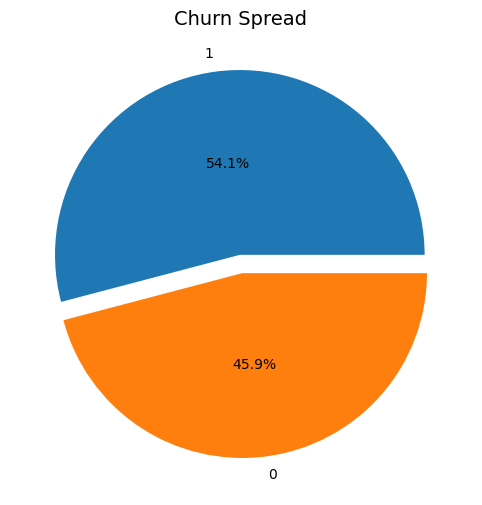

In [13]:
#Using matplotlib
pie, ax = plt.subplots(figsize=[10,6])
labels = churn_spread.keys()
plt.pie(x=churn_spread.values, autopct="%.1f%%", explode=[0.05]*2, labels=labels, pctdistance=0.5)
plt.title("Churn Spread", fontsize=14);

### Missing and Unknown Values

#### Cleaning up `Unknown` datapoints

In [14]:
low_cat = []
for col in categorical_columns :
    if df[col].nunique() < 20:
        low_cat.append(col)

In [15]:
low_cat

['gender',
 'region_category',
 'membership_category',
 'joined_through_referral',
 'preferred_offer_types',
 'medium_of_operation',
 'internet_option',
 'used_special_discount',
 'offer_application_preference',
 'past_complaint',
 'complaint_status',
 'feedback']

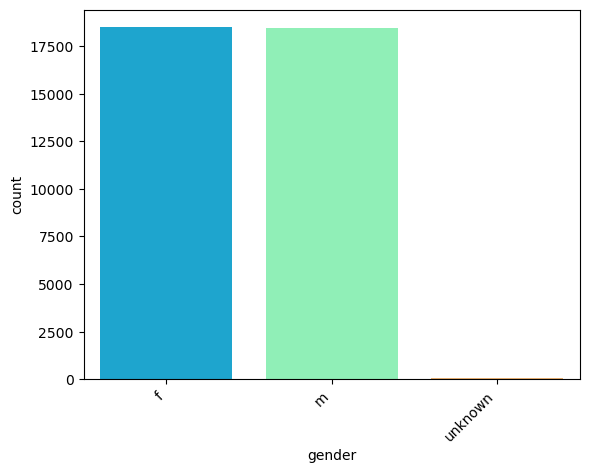

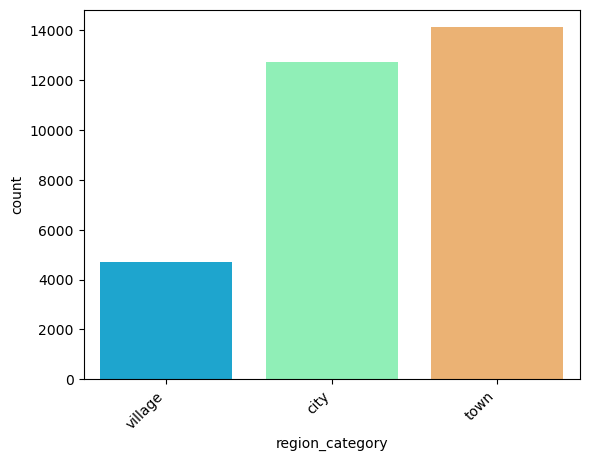

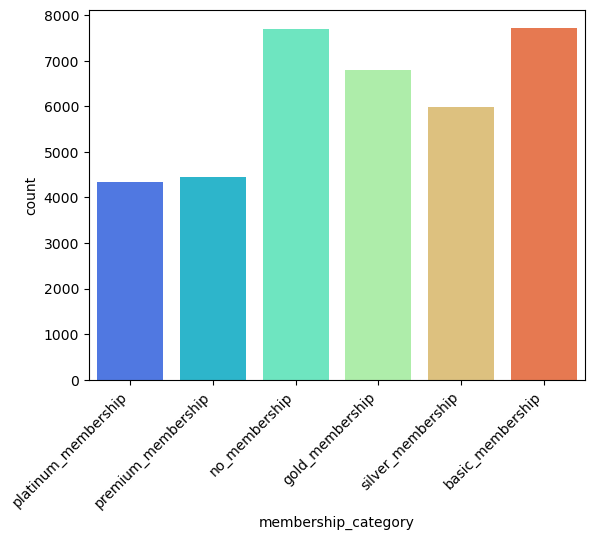

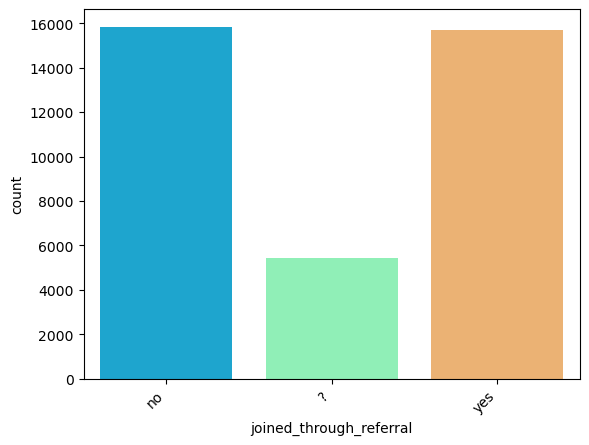

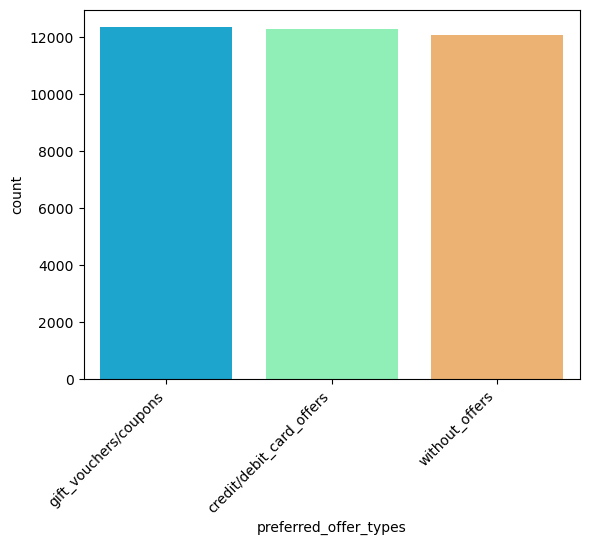

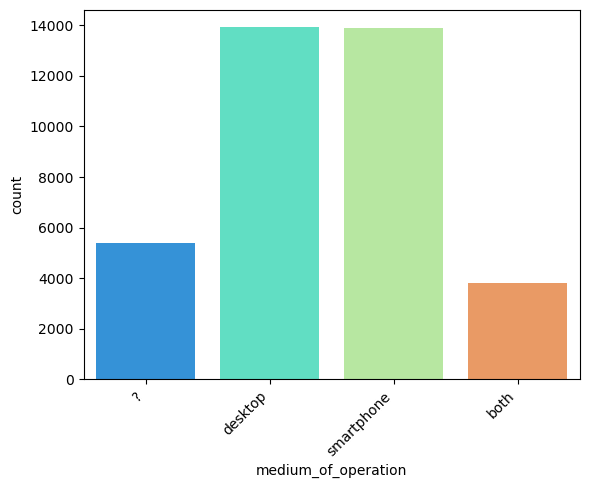

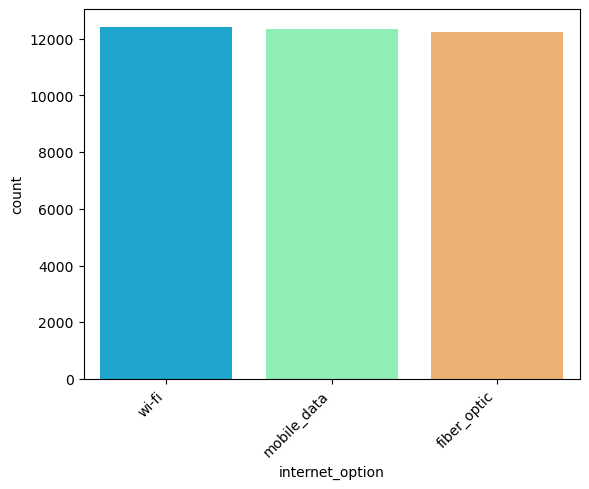

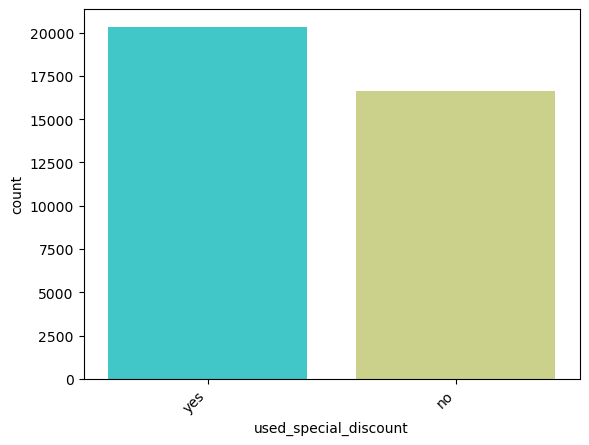

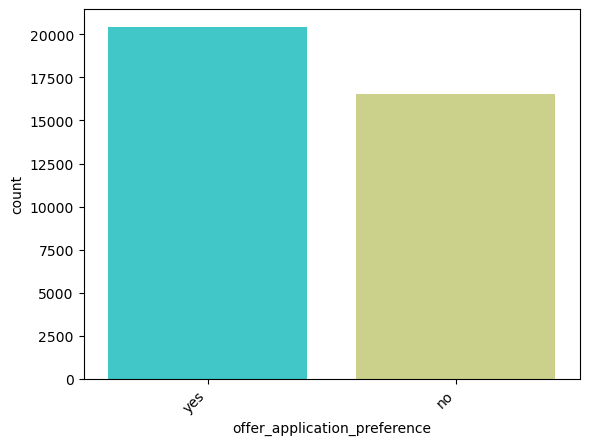

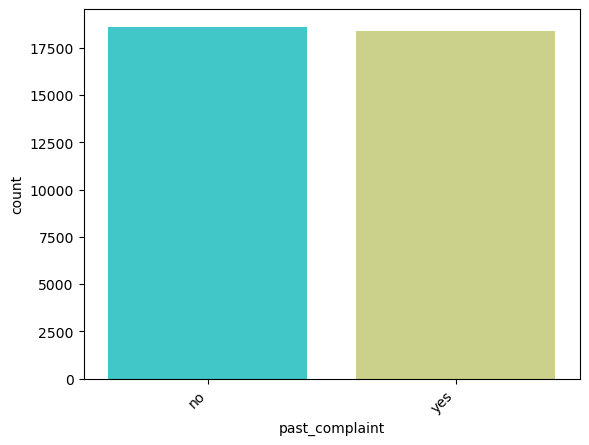

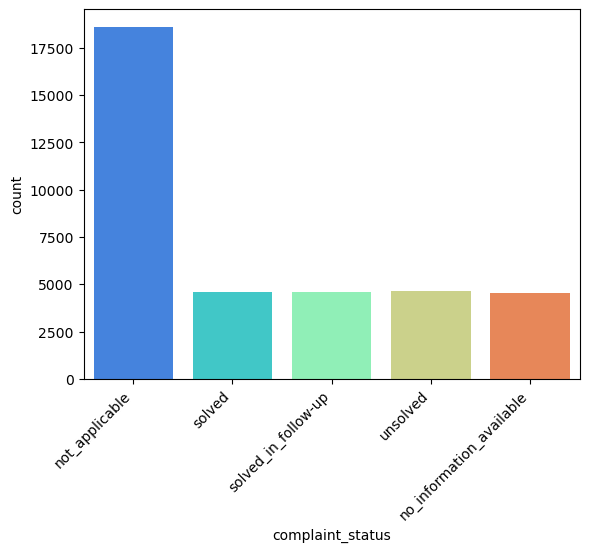

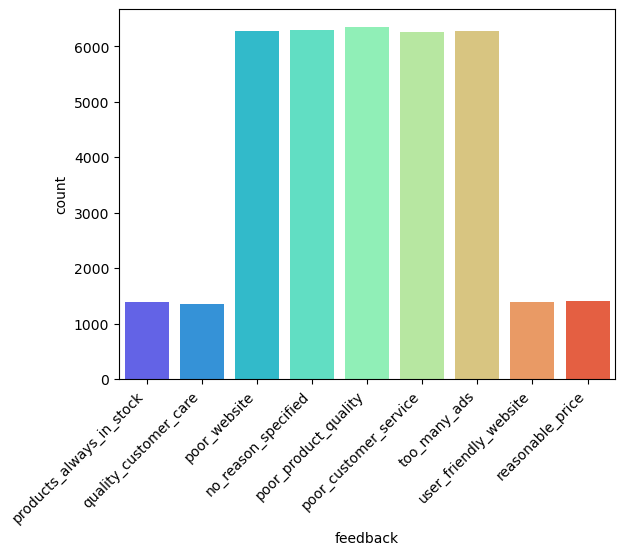

In [16]:
for col in low_cat:
    sns.countplot(x=col,data=df, palette='rainbow')
    plt.xticks(rotation = 45, ha="right")
    plt.show()

There are values that are 'unknown' in some of the columns in the dataset

<b>`Refferal Value count` and `Medium of operation`<b>

In [17]:
df.joined_through_referral.value_counts()

no     15839
yes    15715
?       5438
Name: joined_through_referral, dtype: int64

In [18]:
df.medium_of_operation.value_counts()

desktop       13913
smartphone    13876
?              5393
both           3810
Name: medium_of_operation, dtype: int64

*joined_through_referral and medium_of_operation have ? in their values*

The question mark will be changed to Null Values

In [19]:
for col in ['medium_of_operation', 'joined_through_referral']:
    df[col] = df[col].replace('?', np.NaN)

<b>`Gender`<b>

In [20]:
df.gender.value_counts()

f          18490
m          18443
unknown       59
Name: gender, dtype: int64

Unknown will bereplaced with Null values

In [21]:
df["gender"]=df["gender"].replace("unknown", np.NaN)

<b>`days_since_last_login`<b>

In [22]:
df.days_since_last_login.value_counts()

 12     2380
 13     2373
 14     2307
 15     2278
 11     2262
 10     2091
 16     2068
-999    1999
 9      1863
 17     1747
 8      1571
 18     1444
 7      1442
 19     1308
 6      1257
 5      1234
 20     1184
 21     1015
 4       998
 22      895
 3       852
 23      727
 2       613
 24      471
 1       328
 25      203
 26       82
Name: days_since_last_login, dtype: int64

-999 looks weird so that will be changed to a null value

In [23]:
df["days_since_last_login"]=df["days_since_last_login"].replace(-999, np.NaN)

<b>`Average time spent` and `Points in Wallet`<b>

In [24]:
df.avg_time_spent[df.avg_time_spent < 0]

28      -936.744818
41      -930.207844
60      -615.344319
79      -687.629574
116     -494.083877
            ...    
36794   -977.809108
36819   -910.568433
36956   -746.034591
36987   -650.682759
36988   -638.123421
Name: avg_time_spent, Length: 1719, dtype: float64

In [25]:
df.points_in_wallet[df.points_in_wallet < 0]

67      -549.357498
70       -44.597633
213      -38.084314
340     -288.247333
625     -301.998780
            ...    
35411   -108.057352
35883    -99.476870
35943    -43.109270
36414   -170.497210
36790   -317.024955
Name: points_in_wallet, Length: 136, dtype: float64

There are values lower than 0 in the both columns which does not make sense based on data context

In [26]:
len(df.avg_time_spent[df.avg_time_spent < 0])

1719

In [27]:
len(df.points_in_wallet[df.points_in_wallet < 0])

136

In [28]:
for col in ['avg_time_spent', 'points_in_wallet']:
    df[col]=df[col].apply(lambda x:x if x>=0 else np.nan)

<b>`Average Frequency Login days`<b>

In [29]:
df.avg_frequency_login_days.value_counts()

error                  3522
13.0                   1394
19.0                   1365
8.0                    1361
14.0                   1355
                       ... 
28.191570401129514        1
41.73357294995208         1
-11.515939810499656       1
45.71683637272365         1
27.8399274405269          1
Name: avg_frequency_login_days, Length: 1654, dtype: int64

In [30]:
df['avg_frequency_login_days']=df['avg_frequency_login_days'].apply(lambda x:x if x!='error' else -1)
df['avg_frequency_login_days']=df['avg_frequency_login_days'].astype('float')
df['avg_frequency_login_days']=df['avg_frequency_login_days'].apply(lambda x:x if x>=0 else np.nan)

In [31]:
df.avg_frequency_login_days.value_counts()

13.000000    1394
19.000000    1365
8.000000     1361
14.000000    1355
17.000000    1349
             ... 
46.065501       1
47.095617       1
3.342993        1
29.165844       1
27.839927       1
Name: avg_frequency_login_days, Length: 970, dtype: int64

In [32]:
df["avg_frequency_login_days"]= pd.to_numeric(df["avg_frequency_login_days"], 
                                             errors='coerce')



In [33]:
categorical_columns = list(df.dtypes[df.dtypes == "object"].index)
categorical_columns

['gender',
 'region_category',
 'membership_category',
 'joined_through_referral',
 'preferred_offer_types',
 'medium_of_operation',
 'internet_option',
 'last_visit_time',
 'used_special_discount',
 'offer_application_preference',
 'past_complaint',
 'complaint_status',
 'feedback']

In [34]:
numerical_columns = [col for col in df.columns if col not in categorical_columns and col != 'churn_risk_score']
numerical_columns

['age',
 'days_since_last_login',
 'avg_time_spent',
 'avg_transaction_value',
 'avg_frequency_login_days',
 'points_in_wallet']

In [35]:
for feature in numerical_columns:
    df[feature]= pd.to_numeric(df[feature], errors='coerce')

In [36]:
df.isnull().mean().sort_values(ascending=False)

joined_through_referral         0.147005
region_category                 0.146734
medium_of_operation             0.145788
avg_frequency_login_days        0.113673
points_in_wallet                0.096751
days_since_last_login           0.054039
avg_time_spent                  0.046470
preferred_offer_types           0.007785
gender                          0.001595
used_special_discount           0.000000
feedback                        0.000000
complaint_status                0.000000
past_complaint                  0.000000
offer_application_preference    0.000000
age                             0.000000
avg_transaction_value           0.000000
last_visit_time                 0.000000
internet_option                 0.000000
membership_category             0.000000
churn_risk_score                0.000000
dtype: float64

#### Null Values

In [37]:
df.isnull().mean().sort_values(ascending=False)

joined_through_referral         0.147005
region_category                 0.146734
medium_of_operation             0.145788
avg_frequency_login_days        0.113673
points_in_wallet                0.096751
days_since_last_login           0.054039
avg_time_spent                  0.046470
preferred_offer_types           0.007785
gender                          0.001595
used_special_discount           0.000000
feedback                        0.000000
complaint_status                0.000000
past_complaint                  0.000000
offer_application_preference    0.000000
age                             0.000000
avg_transaction_value           0.000000
last_visit_time                 0.000000
internet_option                 0.000000
membership_category             0.000000
churn_risk_score                0.000000
dtype: float64

The column with the highest number of missing values has 14.7 of it's data missing. We will fill in with mode.

In [38]:
missing_cols = [col for col in df.columns if df[col].isnull().sum() > 0]

## Separate dataset into train and test

Best on practice, We have to split our dataset to Separate dataset into train and test. It is important to separate our data intro training and testing set.

Before we engineer features, some techniques learn parameters from data. It is important to learn these parameters only from the train set. This is to avoid over-fitting.

In [39]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [40]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


In [41]:
y_train = df_train.churn_risk_score
y_val = df_val.churn_risk_score
y_test = df_test.churn_risk_score

In [42]:
del df_train ["churn_risk_score"]
del df_val ["churn_risk_score"]
del df_test["churn_risk_score"]

In [43]:
df_train.shape, df_test.shape

((22194, 19), (7399, 19))

## Feature Engineering

Feature engineering involves changing or manipulating data in columns of data. Splitting before engineering in avoids over fitting.

### Replacing Null Values

In [44]:
len(categorical_columns)

13

<b>`Categorical columns with missing data`<b>

In [45]:
categorical_columns

['gender',
 'region_category',
 'membership_category',
 'joined_through_referral',
 'preferred_offer_types',
 'medium_of_operation',
 'internet_option',
 'last_visit_time',
 'used_special_discount',
 'offer_application_preference',
 'past_complaint',
 'complaint_status',
 'feedback']

In [46]:
cat_col_na = [col for col in categorical_columns
             if df[col].isnull().sum() > 0]

In [47]:
cat_col_na

['gender',
 'region_category',
 'joined_through_referral',
 'preferred_offer_types',
 'medium_of_operation']

In [48]:
df[cat_col_na].isnull().mean().sort_values(ascending=False)

joined_through_referral    0.147005
region_category            0.146734
medium_of_operation        0.145788
preferred_offer_types      0.007785
gender                     0.001595
dtype: float64

In [49]:
# variables to impute with the string missing
with_string_missing = [
    col for col in cat_col_na if df[col].isnull().mean() > 0.1]

# variables to impute with the most frequent category
with_frequent_category = [
    col for col in cat_col_na if df[col].isnull().mean() < 0.1]

In [50]:
with_string_missing

['region_category', 'joined_through_referral', 'medium_of_operation']

In [51]:
# replace missing values with new label: "Missing"

df_full_train[with_string_missing] = df_full_train[with_string_missing].fillna('missing')
df_train[with_string_missing] = df_train[with_string_missing].fillna('missing')
df_val[with_string_missing] = df_val[with_string_missing].fillna('missing')
df_test[with_string_missing] = df_test[with_string_missing].fillna('missing')


In [52]:
## Mode is only gotten from training dataset. Replace with the mode (first value) if there are multiple modes

for col in with_frequent_category:
    
    mode = df_train[col].mode()[0]
    
    df_full_train[col].fillna(mode, inplace=True)
    df_train[col].fillna(mode, inplace=True)
    df_val[col].fillna(mode, inplace=True)
    df_test[col].fillna(mode, inplace=True)


In [53]:
df[cat_col_na].isnull().sum()

gender                       59
region_category            5428
joined_through_referral    5438
preferred_offer_types       288
medium_of_operation        5393
dtype: int64

<b>`Numerical columns with missing data`<b>

In [54]:
num_with_na = [col for col in numerical_columns 
               if df[col].isnull().sum() > 0]

In [55]:
df[num_with_na].isnull().mean()

days_since_last_login       0.054039
avg_time_spent              0.046470
avg_frequency_login_days    0.113673
points_in_wallet            0.096751
dtype: float64

In [56]:
for col in numerical_columns:
    
    median = df_train[col].median()
    
    df_full_train[col].fillna(median, inplace=True)
    df_train[col].fillna(median, inplace=True)
    df_val[col].fillna(median, inplace=True)
    df_test[col].fillna(median, inplace=True)

In [57]:
'''
imputer = KNNImputer(n_neighbors=3)

imputer.fit(df_train[numerical_columns])


df_train[numerical_columns] = pd.DataFrame(imputer.transform(df_train[numerical_columns]))
df_val[numerical_columns] = pd.DataFrame(imputer.transform(df_train[numerical_columns]))
df_test[numerical_columns] = pd.DataFrame(imputer.transform(df_train[numerical_columns]))

'''

'\nimputer = KNNImputer(n_neighbors=3)\n\nimputer.fit(df_train[numerical_columns])\n\n\ndf_train[numerical_columns] = pd.DataFrame(imputer.transform(df_train[numerical_columns]))\ndf_val[numerical_columns] = pd.DataFrame(imputer.transform(df_train[numerical_columns]))\ndf_test[numerical_columns] = pd.DataFrame(imputer.transform(df_train[numerical_columns]))\n\n'

In [58]:
(df_full_train.isnull().sum().sum(), df_train.isnull().sum().sum(), df_val.isnull().sum().sum(), 
     df_test.isnull().sum().sum())

(0, 0, 0, 0)

## Feature Selection

### Feature importance: Churn Rate

In [59]:
df_full_train.head()

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
4218,12,f,city,premium_membership,yes,gift_vouchers/coupons,missing,wi-fi,06:30:06,11.0,48.95,61130.83,1.0,841.04,yes,no,yes,unsolved,products_always_in_stock,0
25030,11,m,town,no_membership,yes,gift_vouchers/coupons,smartphone,fiber_optic,19:10:06,7.0,221.32,6079.76,6.0,545.75,yes,no,no,not_applicable,too_many_ads,1
3665,26,f,city,basic_membership,no,without_offers,desktop,mobile_data,18:07:24,22.0,40.04,15875.07,18.0,618.33,yes,no,no,not_applicable,too_many_ads,1
17256,38,f,village,basic_membership,no,gift_vouchers/coupons,smartphone,wi-fi,04:26:07,21.0,122.12,21442.17,16.0,698.62,yes,no,no,not_applicable,poor_website,1
27908,53,m,town,premium_membership,yes,without_offers,missing,fiber_optic,03:19:22,13.0,1014.73,83142.29,7.0,702.83,yes,yes,yes,unsolved,reasonable_price,0


In [60]:
churn_male = df_full_train[df_full_train.gender == "m"].churn_risk_score.mean()
churn_female = df_full_train[df_full_train.gender == "f"].churn_risk_score.mean()
global_churn = df_full_train.churn_risk_score.mean()

global_churn ,churn_male, churn_female

(0.5394856891832528, 0.5348821411588887, 0.5440424959655729)

In [61]:
df_full_train.membership_category.value_counts()

basic_membership       6162
no_membership          6109
gold_membership        5419
silver_membership      4844
premium_membership     3590
platinum_membership    3469
Name: membership_category, dtype: int64

### Feature importance: Risk Ratio

In [62]:
for c in categorical_columns:
    print(c)
    df_group = df_full_train.groupby(c).churn_risk_score.agg(["mean", "count"])
    df_group["dif"] = df_group['mean'] - global_churn
    df_group["risk"] = df_group['mean'] / global_churn
    display(df_group)
    print()

gender


,mean,count,dif,risk
gender,,,,
f,0.544042,14872,0.004557,1.008447
m,0.534882,14721,-0.004604,0.991467



region_category


,mean,count,dif,risk
region_category,,,,
city,0.544631,10150,0.005145,1.009537
missing,0.548484,4321,0.008998,1.016680
town,0.542391,11335,0.002905,1.005385
village,0.506734,3787,-0.032752,0.939290



membership_category


,mean,count,dif,risk
membership_category,,,,
basic_membership,0.967705,6162,0.428220,1.793755
gold_membership,0.373870,5419,-0.165616,0.693011
no_membership,0.970208,6109,0.430722,1.798394
platinum_membership,0.000000,3469,-0.539486,0.000000
premium_membership,0.000000,3590,-0.539486,0.000000
silver_membership,0.422998,4844,-0.116488,0.784076



joined_through_referral


,mean,count,dif,risk
joined_through_referral,,,,
missing,0.550627,4306,0.011141,1.020652
no,0.520365,12718,-0.019121,0.964557
yes,0.555016,12569,0.015531,1.028788



preferred_offer_types


,mean,count,dif,risk
preferred_offer_types,,,,
credit/debit_card_offers,0.538847,9782,-0.000639,0.998816
gift_vouchers/coupons,0.512706,10074,-0.026780,0.950361
without_offers,0.567834,9737,0.028348,1.052547



medium_of_operation


,mean,count,dif,risk
medium_of_operation,,,,
both,0.517770,3067,-0.021716,0.959747
desktop,0.532370,11075,-0.007115,0.986811
missing,0.541231,4305,0.001745,1.003235
smartphone,0.551857,11146,0.012371,1.022932



internet_option


,mean,count,dif,risk
internet_option,,,,
fiber_optic,0.542808,9788,0.003322,1.006157
mobile_data,0.540521,9822,0.001036,1.001920
wi-fi,0.535210,9983,-0.004276,0.992074



last_visit_time


,mean,count,dif,risk
last_visit_time,,,,
00:00:00,0.0,1,-0.539486,0.000000
00:00:03,1.0,1,0.460514,1.853617
00:00:04,1.0,1,0.460514,1.853617
00:00:09,0.0,1,-0.539486,0.000000
00:00:13,0.0,1,-0.539486,0.000000
...,...,...,...,...
23:59:52,0.5,2,-0.039486,0.926809
23:59:55,0.5,2,-0.039486,0.926809
23:59:56,1.0,1,0.460514,1.853617



used_special_discount


,mean,count,dif,risk
used_special_discount,,,,
no,0.542864,13228,0.003378,1.006261
yes,0.536755,16365,-0.002730,0.994939



offer_application_preference


,mean,count,dif,risk
offer_application_preference,,,,
no,0.551696,13328,0.012210,1.022633
yes,0.529480,16265,-0.010005,0.981454



past_complaint


,mean,count,dif,risk
past_complaint,,,,
no,0.533737,14865,-0.005749,0.989344
yes,0.545288,14728,0.005802,1.010755



complaint_status


,mean,count,dif,risk
complaint_status,,,,
no_information_available,0.554668,3631,0.015182,1.028142
not_applicable,0.533737,14865,-0.005749,0.989344
solved,0.547767,3695,0.008282,1.015351
solved_in_follow-up,0.548090,3691,0.008604,1.015949
unsolved,0.530854,3711,-0.008631,0.984001



feedback


,mean,count,dif,risk
feedback,,,,
no_reason_specified,0.627596,5008,0.088110,1.163323
poor_customer_service,0.645833,5040,0.106348,1.197128
poor_product_quality,0.646908,5061,0.107422,1.199119
poor_website,0.634181,4997,0.094695,1.175528
products_always_in_stock,0.000000,1101,-0.539486,0.000000
quality_customer_care,0.000000,1089,-0.539486,0.000000
reasonable_price,0.000000,1143,-0.539486,0.000000
too_many_ads,0.618859,5048,0.079373,1.147128
user_friendly_website,0.000000,1106,-0.539486,0.000000


### Feature importance: Mutual Information

Mutual information - concept from information theory, it tells us how much we can learn about one variable if we know the value of another.

If we observe all the variables, how much do we learn about the target variables. If we observe that this customer has a gold_membership, how much do we know about churn? The higher the score, the higher the importance of the variable on the target variable. Imported from sklearn: from sklearn.metrics import mutual_info_score.

Same value regardless of the order
mutual_info_score(df_full_train.gender, df_full_train.contract)

In [63]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.churn_risk_score)

In [64]:
mi=df_full_train[categorical_columns].apply(mutual_info_churn_score)
mi.sort_values(ascending = False)

last_visit_time                 0.586491
membership_category             0.400112
feedback                        0.132288
preferred_offer_types           0.001024
joined_through_referral         0.000559
region_category                 0.000324
medium_of_operation             0.000253
offer_application_preference    0.000246
complaint_status                0.000145
past_complaint                  0.000067
gender                          0.000042
internet_option                 0.000020
used_special_discount           0.000019
dtype: float64

From the score, it is obvious that the features with the higher mutual scores have a greater impact on the churn of the customers.

### Feature importance: Correlation

This is a way to measure the importance of numerical columns

- Correlation coefficient:- Pearson_correlation_coefficient

In [65]:
df_full_train[numerical_columns]

,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet
4218,12,11.0,48.95,61130.83,1.0,841.04
25030,11,7.0,221.32,6079.76,6.0,545.75
3665,26,22.0,40.04,15875.07,18.0,618.33
17256,38,21.0,122.12,21442.17,16.0,698.62
27908,53,13.0,1014.73,83142.29,7.0,702.83
...,...,...,...,...,...,...
7813,43,7.0,1554.71,2936.24,11.0,798.08
32511,61,16.0,174.43,42268.72,20.0,628.51
5192,30,13.0,91.44,47192.43,15.0,773.11
12172,28,5.0,317.29,29055.58,19.0,656.36


In [66]:
corr_matrix = df_full_train[numerical_columns].corr()
corr_matrix

,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet
age,1.000000,-0.003425,-0.003142,0.002867,-0.003634,0.000674
days_since_last_login,-0.003425,1.000000,-0.109301,-0.020670,0.011240,-0.003200
avg_time_spent,-0.003142,-0.109301,1.000000,0.023144,0.001489,-0.002323
avg_transaction_value,0.002867,-0.020670,0.023144,1.000000,-0.130136,0.085898
avg_frequency_login_days,-0.003634,0.011240,0.001489,-0.130136,1.000000,-0.046086
points_in_wallet,0.000674,-0.003200,-0.002323,0.085898,-0.046086,1.000000


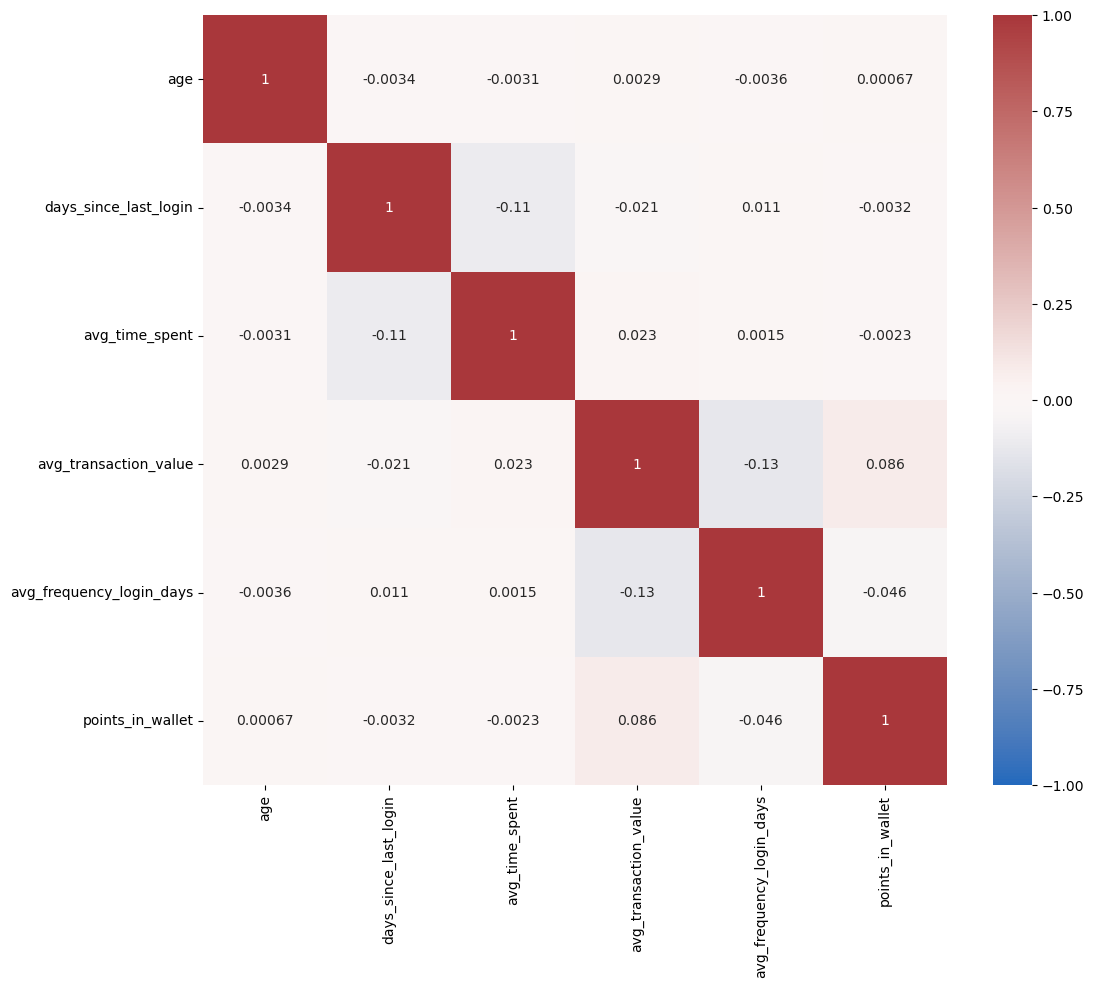

In [67]:
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, vmax=1, vmin=-1, center=0, cmap='vlag', annot=True)
plt.savefig('corr_pic', bbox_inches='tight')
plt.show()

In [68]:
## Most correlated features

# Retain upper triangular values of correlation matrix and
# make Lower triangular values Null
upper_corr_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

upper_corr_matrix.unstack().transpose().sort_values( ascending=False).dropna()

points_in_wallet          avg_transaction_value       0.085898
avg_transaction_value     avg_time_spent              0.023144
avg_frequency_login_days  days_since_last_login       0.011240
avg_transaction_value     age                         0.002867
avg_frequency_login_days  avg_time_spent              0.001489
points_in_wallet          age                         0.000674
                          avg_time_spent             -0.002323
avg_time_spent            age                        -0.003142
points_in_wallet          days_since_last_login      -0.003200
days_since_last_login     age                        -0.003425
avg_frequency_login_days  age                        -0.003634
avg_transaction_value     days_since_last_login      -0.020670
points_in_wallet          avg_frequency_login_days   -0.046086
avg_time_spent            days_since_last_login      -0.109301
avg_frequency_login_days  avg_transaction_value      -0.130136
dtype: float64

## Logistic Regression

### Model Training

In [69]:
dv = DictVectorizer(sparse = False)

train_dicts = df_train[categorical_columns + numerical_columns].to_dict(orient = "records")
X_train = dv.fit_transform(train_dicts)

model =LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [70]:
val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient = "records")
X_val = dv.transform(val_dict)


## probability [0,1] is why it is dimesnsional
y_pred = model.predict_proba(X_val)[:,1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8730909582375996

### Confusion table

- Different types of errors and correct decisions
- Arranging them in a table

In [71]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [72]:
t = 0.5

predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [73]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [74]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [75]:
tp,tn

(3303, 3157)

In [76]:
fp,fn

(209, 730)

In [77]:
confusion_matrix = np.array([
    [ tn, fp ],
    [ fn, tp ]
])

confusion_matrix

array([[3157,  209],
       [ 730, 3303]], dtype=int64)

In [78]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.43, 0.03],
       [0.1 , 0.45]])

### Precison and recall

In [79]:
###Another way of calculating accuracy
(tp + tn) / (tp + tn + fn + fp) 

0.8730909582375996

Precision = TP / ALL_POSITIVE (# positive ==> all that were predicted to churn).



In [80]:
precision = tp / (tp + fp)
precision

0.9404897494305239

This means that 7% are approximately mistakes - people who were not meant to get the promotional email

In [81]:
tp, (tp + fp)

(3303, 3512)

Recall = Fraction of correctly identified positive examples. This means that people that were going to churn and we are looking for the fraction of correctly identified churn.

Recall = TP / #POSITIVE OBVERSATIONS

Positive observations here means all the people that actually churned

In [82]:
recall = tp /(tp + fn)
recall


0.8189933052318373

The recall here is 86% meaning we failed to identify 14% of people who are churning. Recall here means we are looking at the customers that are actually churning

In [83]:
# List to store values of thresholds, tp, fp, fn, and tn
scores = []

# Array of 101 thresholds between 0 and 1 with step 0.01
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    # actual class labels
    actual_positive = y_val == 1
    actual_negative = y_val == 0
    
    # predicted class labels along different thresholds
    predict_positive = y_pred >= t
    predict_negative = y_pred < t
    
    # number of true positive and true negative
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    # number of false positive and false negative
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [84]:
# Convert scores list to dataframe
df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,4033,3366,0,0
10,0.1,4030,2360,3,1006
20,0.2,4003,1335,30,2031
30,0.3,3952,1143,81,2223
40,0.4,3772,666,261,2700
50,0.5,3303,209,730,3157
60,0.6,3089,130,944,3236
70,0.7,3056,103,977,3263
80,0.8,2978,88,1055,3278
90,0.9,2778,84,1255,3282


In [85]:
# Calculate and create columns for precision and recall
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores [::10]

,threshold,tp,fp,fn,tn,precision,recall
0,0.0,4033,3366,0,0,0.545074,1.000000
10,0.1,4030,2360,3,1006,0.630673,0.999256
20,0.2,4003,1335,30,2031,0.749906,0.992561
30,0.3,3952,1143,81,2223,0.775662,0.979916
40,0.4,3772,666,261,2700,0.849932,0.935284
50,0.5,3303,209,730,3157,0.940490,0.818993
60,0.6,3089,130,944,3236,0.959615,0.765931
70,0.7,3056,103,977,3263,0.967395,0.757749
80,0.8,2978,88,1055,3278,0.971298,0.738408
90,0.9,2778,84,1255,3282,0.970650,0.688817


In [86]:
df_scores["tpr"] = df_scores.tp /(df_scores.tp + df_scores.fn)
df_scores["fpr"] = df_scores.fp /(df_scores.fp + df_scores.tn)

df_scores [::10]

,threshold,tp,fp,fn,tn,precision,recall,tpr,fpr
0,0.0,4033,3366,0,0,0.545074,1.000000,1.000000,1.000000
10,0.1,4030,2360,3,1006,0.630673,0.999256,0.999256,0.701129
20,0.2,4003,1335,30,2031,0.749906,0.992561,0.992561,0.396613
30,0.3,3952,1143,81,2223,0.775662,0.979916,0.979916,0.339572
40,0.4,3772,666,261,2700,0.849932,0.935284,0.935284,0.197861
50,0.5,3303,209,730,3157,0.940490,0.818993,0.818993,0.062092
60,0.6,3089,130,944,3236,0.959615,0.765931,0.765931,0.038622
70,0.7,3056,103,977,3263,0.967395,0.757749,0.757749,0.030600
80,0.8,2978,88,1055,3278,0.971298,0.738408,0.738408,0.026144
90,0.9,2778,84,1255,3282,0.970650,0.688817,0.688817,0.024955


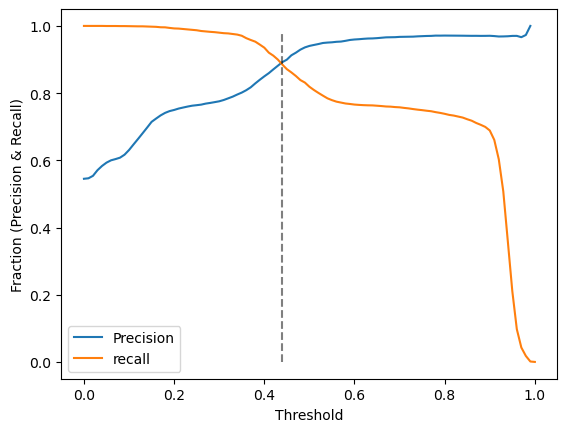

In [89]:
# Plot precision and recall scores along with different thresholds
plt.plot(df_scores.threshold, df_scores.precision, label='Precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')
plt.xlabel('Threshold')
plt.ylabel('Fraction (Precision & Recall)')
plt.vlines(0.44, 0, 0.98, color='black', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

### F1 score

Precision and reacll are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both.

 
Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01.

At which threshold F1 is maximal?

In [90]:
# Calculate and create 'F1' column
df_scores['f1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)
df_scores[::10]

,threshold,tp,fp,fn,tn,precision,recall,tpr,fpr,f1
0,0.0,4033,3366,0,0,0.545074,1.000000,1.000000,1.000000,0.705563
10,0.1,4030,2360,3,1006,0.630673,0.999256,0.999256,0.701129,0.773290
20,0.2,4003,1335,30,2031,0.749906,0.992561,0.992561,0.396613,0.854338
30,0.3,3952,1143,81,2223,0.775662,0.979916,0.979916,0.339572,0.865907
40,0.4,3772,666,261,2700,0.849932,0.935284,0.935284,0.197861,0.890568
50,0.5,3303,209,730,3157,0.940490,0.818993,0.818993,0.062092,0.875547
60,0.6,3089,130,944,3236,0.959615,0.765931,0.765931,0.038622,0.851903
70,0.7,3056,103,977,3263,0.967395,0.757749,0.757749,0.030600,0.849833
80,0.8,2978,88,1055,3278,0.971298,0.738408,0.738408,0.026144,0.838991
90,0.9,2778,84,1255,3282,0.970650,0.688817,0.688817,0.024955,0.805801


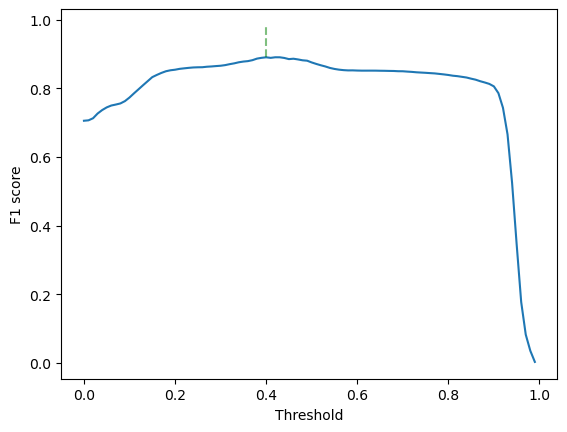

In [93]:
# Plot f1 scores along with different thresholds
plt.plot(df_scores.threshold, df_scores.f1)
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.vlines(0.4, 0.89, 0.982, color='green', linestyle='--', alpha=0.5)

plt.show()

## Decision Trees

### Decision trees parameter tuning

* selecting `max_depth`
* selecting `min_samples_leaf`

In [94]:
### Playing with the max depth in the decision Tree class
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.824
   2 -> 0.878
   3 -> 0.925
   4 -> 0.940
   5 -> 0.960
   6 -> 0.972
  10 -> 0.976
  15 -> 0.960
  20 -> 0.930


From the results above, depths 5,6,10 have the best auc. Looping with those depths and a new list of min samples

In [95]:
scores = []

for depth in [5, 6, 10]:
    for s in [1, 5, 10, 15, 20, 50]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [96]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [97]:
df_scores.head()

,max_depth,min_samples_leaf,auc
0,5,1,0.959926
1,5,5,0.959522
2,5,10,0.959530
3,5,15,0.959541
4,5,20,0.959690


In [98]:
df_scores.sort_values(by='auc', ascending=False)

,max_depth,min_samples_leaf,auc
14,10,10,0.977592
15,10,15,0.977478
16,10,20,0.976828
12,10,1,0.976136
17,10,50,0.975873
13,10,5,0.975590
7,6,5,0.972723
9,6,15,0.972691
8,6,10,0.972519
10,6,20,0.972511


In [99]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)

## Ensembles and random forest

- Ensembling models
- Random forest - ensembling decision trees
- Tuning random forest

Random forest means having multiple decision trees and going with the average. It's like having a panel of experts in a loan application and going with the most distribution. Each of the trees get a different (random) set of features.

This takes significantly long to run. 

In [100]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [101]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

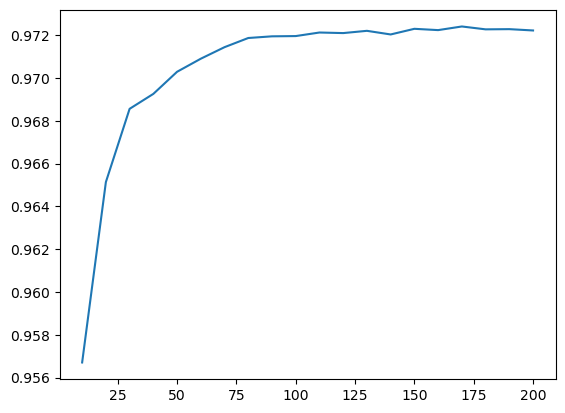

In [102]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [103]:
df_scores

,n_estimators,auc
0,10,0.956708
1,20,0.965139
2,30,0.968562
3,40,0.969260
4,50,0.970294
5,60,0.970905
6,70,0.971444
7,80,0.971872
8,90,0.971950
9,100,0.971962


### Random forest Hyper parameter Tuning

In [104]:
## For 50
scores = []

for d in [5, 10, 15]:
    rf = RandomForestClassifier(n_estimators=50,
                                max_depth=d,
                                random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    scores.append((d, auc))

In [107]:
scores = []

for d in [5, 10, 15]:
    for n in [50, 110, 150]:
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

scores

[(5, 50, 0.9637251808055911),
 (5, 110, 0.9653191311313276),
 (5, 150, 0.9630542454341698),
 (10, 50, 0.9607152901810214),
 (10, 110, 0.9656987974581067),
 (10, 150, 0.9648105152692309),
 (15, 50, 0.9641964488159847),
 (15, 110, 0.9660820365083722),
 (15, 150, 0.9662583890862361)]

In [108]:
scores

[(5, 50, 0.9637251808055911),
 (5, 110, 0.9653191311313276),
 (5, 150, 0.9630542454341698),
 (10, 50, 0.9607152901810214),
 (10, 110, 0.9656987974581067),
 (10, 150, 0.9648105152692309),
 (15, 50, 0.9641964488159847),
 (15, 110, 0.9660820365083722),
 (15, 150, 0.9662583890862361)]

In [109]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

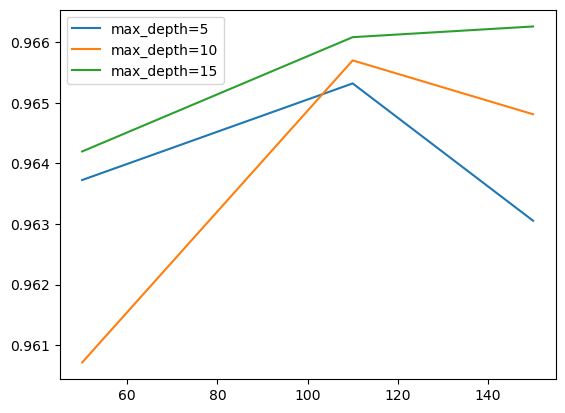

In [110]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [116]:
### 10 is the best value
max_depth =15


In [117]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in [50,110,150]:
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [118]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores.head()

,min_samples_leaf,n_estimators,auc
0,1,50,0.964196
1,1,110,0.966082
2,1,150,0.966258
3,3,50,0.962431
4,3,110,0.962885


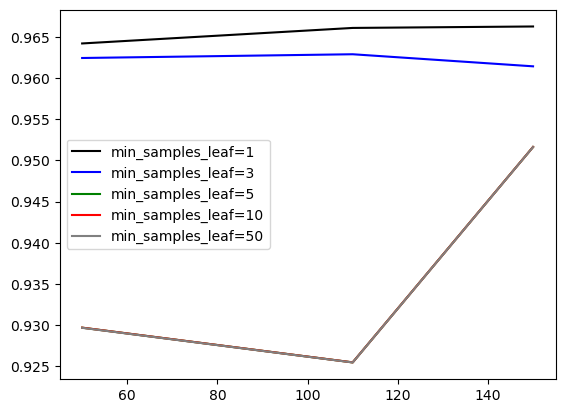

In [123]:
colors = ['black', 'blue', 'green', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [122]:
df_scores

,min_samples_leaf,n_estimators,auc
0,1,50,0.964196
1,1,110,0.966082
2,1,150,0.966258
3,3,50,0.962431
4,3,110,0.962885
5,3,150,0.961419
6,5,50,0.929680
7,5,110,0.925461
8,5,150,0.951623
9,10,50,0.929683


Choosen parameters:-

min_samples_leaf = 1
max_depth = 15
n_estimators = 150

In [125]:
rf = RandomForestClassifier(n_estimators=150,
                            max_depth=15,
                            min_samples_leaf=1,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=150, random_state=1)

## Gradient boosting and XGBoost
- Gradient boosting vs random forest
- Installing XGBoost
- Training the first model
- Performance monitoring
- Parsing xgboost's monitoring output

In [128]:
import xgboost as xgb

In [129]:
##wrap in a special structure called DMAtrix
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

C:\Users\eddye\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [130]:
## eta is learning rate
#min_child_weight is same as min_sample leaf.

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [131]:
y_pred = model.predict(dval)


In [132]:
roc_auc_score(y_val, y_pred)

0.9771474609574988

In [134]:
## see what is happening
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [138]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

##verbose_evals -- print at every 10 steps
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=10,
                  evals=watchlist)


In [139]:
print(output.stdout)

[0]	train-auc:0.96948	val-auc:0.97193
[10]	train-auc:0.98088	val-auc:0.97597
[20]	train-auc:0.98499	val-auc:0.97711
[30]	train-auc:0.98798	val-auc:0.97756
[40]	train-auc:0.99069	val-auc:0.97783
[50]	train-auc:0.99252	val-auc:0.97740
[60]	train-auc:0.99377	val-auc:0.97739
[70]	train-auc:0.99498	val-auc:0.97735
[80]	train-auc:0.99587	val-auc:0.97720
[90]	train-auc:0.99684	val-auc:0.97736
[100]	train-auc:0.99764	val-auc:0.97730
[110]	train-auc:0.99802	val-auc:0.97722
[120]	train-auc:0.99851	val-auc:0.97729
[130]	train-auc:0.99901	val-auc:0.97678
[140]	train-auc:0.99929	val-auc:0.97681
[150]	train-auc:0.99951	val-auc:0.97667
[160]	train-auc:0.99972	val-auc:0.97643
[170]	train-auc:0.99983	val-auc:0.97650
[180]	train-auc:0.99989	val-auc:0.97648
[190]	train-auc:0.99993	val-auc:0.97648
[199]	train-auc:0.99996	val-auc:0.97652



In [140]:
s = output.stdout

In [141]:
print(s[:200])

[0]	train-auc:0.96948	val-auc:0.97193
[10]	train-auc:0.98088	val-auc:0.97597
[20]	train-auc:0.98499	val-auc:0.97711
[30]	train-auc:0.98798	val-auc:0.97756
[40]	train-auc:0.99069	val-auc:0.97783
[50]	t


In [142]:
def parse_xgb_output(output):  
    results = []
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])


        results.append((it, train, val))

    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    
    return df_results


In [143]:
df_score = parse_xgb_output(output)


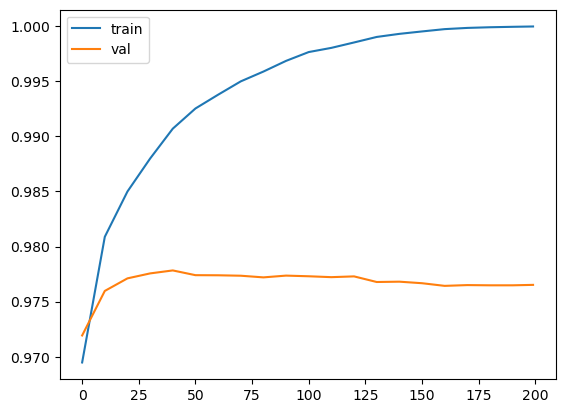

In [144]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

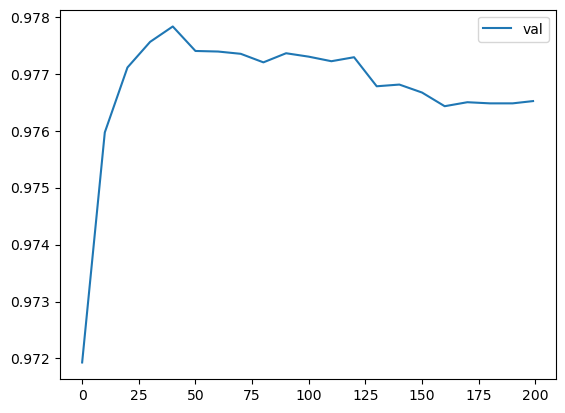

In [145]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

## Evaluation metrics

### Accuracy Score

In [146]:
### creating a loop of churn decisions to ascertain best decision

thresholds = np.linspace(0,1,21)
scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print("%.2f %.3f" % (t,score))
    scores.append(score)

0.00 0.545
0.05 0.889
0.10 0.914
0.15 0.917
0.20 0.919
0.25 0.920
0.30 0.926
0.35 0.929
0.40 0.933
0.45 0.938
0.50 0.937
0.55 0.935
0.60 0.933
0.65 0.932
0.70 0.932
0.75 0.931
0.80 0.931
0.85 0.930
0.90 0.925
0.95 0.503
1.00 0.455


In [147]:
scores

[0.5450736586025139,
 0.8889039059332342,
 0.9140424381673199,
 0.9174212731450196,
 0.9193134207325314,
 0.9199891877280714,
 0.9255304770914988,
 0.9293147722665225,
 0.9325584538451142,
 0.9378294364103257,
 0.9374239762130018,
 0.934585754831734,
 0.9325584538451142,
 0.9322881470468982,
 0.9320178402486823,
 0.9312069198540344,
 0.9306663062576024,
 0.9299905392620624,
 0.9247195566968509,
 0.5027706446817137,
 0.45492634139748617]

## Picking the final model

### Logistic Regression

In [149]:
dv = DictVectorizer(sparse = False)

train_dicts = df_train[categorical_columns + numerical_columns].to_dict(orient = "records")
X_train = dv.fit_transform(train_dicts)

model =LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [150]:
y_pred = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9522933864542067

### Decison Tree

In [151]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.977555377582361

In [152]:
roc_auc_score(y_val, y_pred)

0.977555377582361

Decision Tree classifier had a very good acccuracy so I went with that.

### Random Forect classifier

In [153]:
rf = RandomForestClassifier(n_estimators=150,
                            max_depth=15,
                            min_samples_leaf=1,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=150, random_state=1)

In [154]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9662583890862361

N/B: Although Xgboost had a good score but it was not choosen. Wanted to try deploying a different model altogether

## BENTOML

In [156]:
import bentoml


In [157]:
import json

In [158]:
request = df_test.iloc[0].to_dict()
print(json.dumps(request, indent=2))

{
  "age": 12,
  "gender": "m",
  "region_category": "missing",
  "membership_category": "silver_membership",
  "joined_through_referral": "no",
  "preferred_offer_types": "credit/debit_card_offers",
  "medium_of_operation": "smartphone",
  "internet_option": "fiber_optic",
  "last_visit_time": "13:38:19",
  "days_since_last_login": 24.0,
  "avg_time_spent": 121.82,
  "avg_transaction_value": 30385.88,
  "avg_frequency_login_days": 25.0,
  "points_in_wallet": 698.62,
  "used_special_discount": "no",
  "offer_application_preference": "yes",
  "past_complaint": "yes",
  "complaint_status": "solved",
  "feedback": "too_many_ads"
}


### Create new bento tag

In [159]:
# `save` a given classifier and retrieve coresponding tag:
tag = bentoml.sklearn.save_model('decision_tree', dt, 
                                 custom_objects = {
                                     "dictVectorizer":dv
                                 }, signatures={
                                    "predict_proba":{
                                        "batchable": True,
                                        "batch_dim": 0
                                    }})

In [160]:
tag

Model(tag="decision_tree:xszfph3bdo5tzshc", path="C:\Users\eddye\bentoml\models\decision_tree\xszfph3bdo5tzshc\")

Run train.py file as instructed in github repository. Follow through the readme file to create and reproduce project.

Happy Coding!

------